# EDA

##### Libraries

In [2]:
import re
import emoji
import torch
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## Data

#### Geo Reviews Dataset 2023

Sources: 

- [GitHub](https://github.com/yandex/geo-reviews-dataset-2023)    
- [HuggingFace](https://huggingface.co/datasets/d0rj/geo-reviews-dataset-2023/tree/main)

#### Overview

In [ ]:
# Загружаем данные
# data_full = pd.read_csv('data/data.csv')
data_full = pd.read_parquet("hf://datasets/d0rj/geo-reviews-dataset-2023/data/train-00000-of-00001-49261e4e5a35a5a0.parquet")

In [328]:
# Проверим наличие дубликатов в колонке 'text'
duplicate_count = data_full['text'].duplicated().sum()
print(f"Number of duplicate texts: {duplicate_count}")

Number of duplicate texts: 115


В данных **115** строк с дублирующимся текстом, их можно удалить для уменьшения избыточности данных

In [329]:
# Проверим количество строк с пропущенными значениями
na_rows_count = data_full.isna().any(axis=1).sum()
print(f"Number of rows with missing values: {na_rows_count}")

Number of rows with missing values: 970


Тут мы видим, что в данных есть **970** строк с пропущенными значениями.

In [330]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  499030 non-null  object
 2   rating   500000 non-null  int64 
 3   rubrics  500000 non-null  object
 4   text     500000 non-null  object
dtypes: int64(1), object(4)
memory usage: 19.1+ MB


Датафрейм состоит из **500 000** строк, и в нем есть пропущенные значения только в колонке `name_ru`. Остальные колонки (`address`, `rating`, `rubrics`, `text`) заполнены без пропусков.

In [331]:
# Удаляем дубликаты текстов
# data_full.dropna(inplace=True)
data_full.drop_duplicates(subset='text', inplace=True)

Оставляем строки с пропущенными значениями в других колонках, так как они не влияют на столбец `text`. Колонки `name_ru` и `address` не будут использоваться в обучении модели, поэтому мы можем их оставить без изменений, чтобы сохранить больше текстов для анализа.

#### Data Exporation

In [332]:
# Обзор
data_full.head(3)

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."


In [333]:
# Анализ уникальных значений
unique_names = data_full['name_ru'].nunique()
print(f"Unique names: {unique_names}")

Unique names: 148442


В датафрейме **148 442** уникальных значений в колонке `name_ru`, что соответствует количеству различных объектов / брендов.

In [334]:
# Рассмотрим распределение рейтингов по каждому уникальному значению
rating_distribution = data_full.groupby('name_ru')['rating'].value_counts().unstack(fill_value=0)

# Переименовываем столбцы
rating_distribution.columns = [f'rating {col}' for col in rating_distribution.columns]

# Считаем количество отзывов
text_counts = data_full['name_ru'].value_counts().rename('reviews')

# Объединяем данные в одну таблицу
place_summary = pd.concat([text_counts, rating_distribution], axis=1).fillna(0).astype(int)

# Отображаем первые 10 строк
display(place_summary.head(10))

,reviews,rating 0,rating 1,rating 2,rating 3,rating 4,rating 5
name_ru,,,,,,,
Пятёрочка,6027,6,347,162,339,852,4321
Магнит,2609,1,245,104,230,405,1624
Красное&Белое,1731,1,89,41,83,222,1295
Wildberries,1693,1,168,20,40,106,1358
Ozon,1493,0,153,44,48,68,1180
Вкусно — и точка,1180,0,241,71,124,139,605
Перекрёсток,1156,0,88,29,75,144,820
Fix Price,1111,0,68,22,99,178,744
Пляж,1090,3,37,43,109,174,724


In [335]:
# Анализ уникальных значений
unique_rubrics = data_full['rubrics'].nunique()
print(f"Unique rubrics: {unique_rubrics}")

Unique rubrics: 31792


В датафрейме **31723** уникальных значений в колонке `rubrics`, которые представляют различные категории, такие как 'Гостиница', 'Ресторан', 'Кафе' и т.д.

In [336]:
# Рассмотрим распределение рейтингов по рубрикам
rating_distribution = data_full.groupby('rubrics')['rating'].value_counts().unstack(fill_value=0)

# Переименовываем столбцы
rating_distribution.columns = [f'rating {col}' for col in rating_distribution.columns]

# Считаем количество отзывов
text_counts = data_full['rubrics'].value_counts().rename('reviews')

# Объединяем данные в одну таблицу
rubrics_summary = pd.concat([text_counts, rating_distribution], axis=1).fillna(0).astype(int)

# Отображаем первые 10 строк
display(rubrics_summary.head(10))

,reviews,rating 0,rating 1,rating 2,rating 3,rating 4,rating 5
rubrics,,,,,,,
Гостиница,42236,24,1445,1077,2522,5820,31348
Ресторан,14613,2,705,431,818,1382,11275
Кафе,12363,6,860,429,711,1196,9161
Супермаркет,8891,7,514,255,574,1348,6193
Магазин продуктов,5284,1,319,147,361,710,3746
Музей,5003,3,76,60,135,409,4320
Быстрое питание,4900,0,702,253,363,524,3058
Ресторан;Кафе,4553,3,207,141,231,411,3560
Супермаркет;Магазин продуктов,4540,3,391,170,387,671,2918


Тут мы видим,что некоторые рубрики содержат комбинации или сочетания нескольких категорий, что увеличивает их количество.

In [337]:
# Выделяем количество уникальных рубрик без комбинаций
unique_rubrics = set()

# Проходим по каждой записи в столбце 'rubrics'
for rubrics in data_full['rubrics']:
    # Разделяем рубрики по ';' и добавляем в множество
    for rubric in rubrics.split(';'):
        unique_rubrics.add(rubric.strip())

# Сортируем уникальные рубрики
unique_rubrics = sorted(unique_rubrics)

# Выводим количество уникальных рубрик
print(f"Number of unique rubrics: {len(unique_rubrics)}")

Number of unique rubrics: 1370


После обработки данных мы обнаружили, что в колонке `rubrics` содержится **1370** уникальных значений.

#### Visual Insights

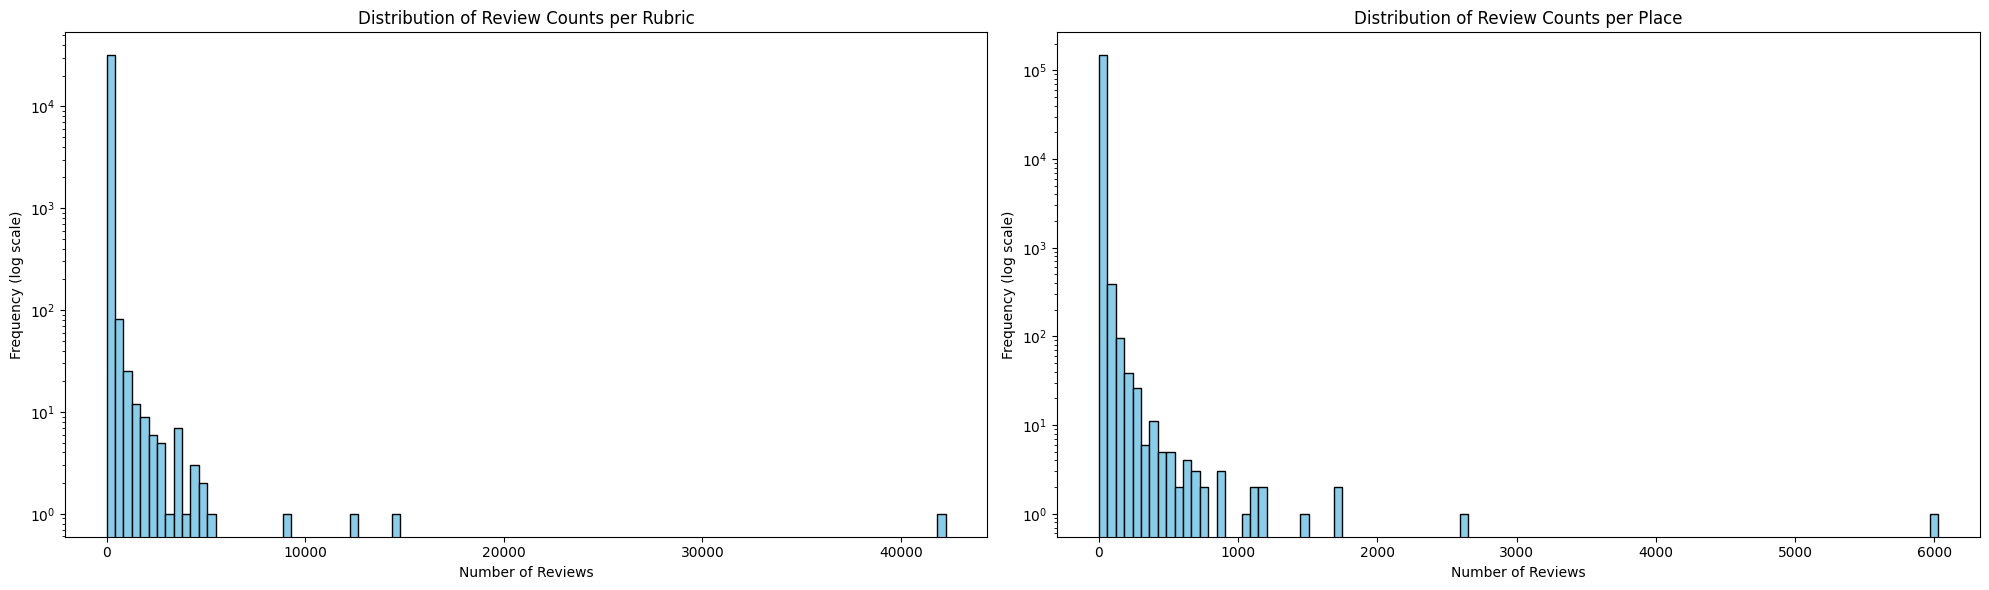

In [338]:
# Создаем подграфики
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

color = 'skyblue'
edgecolor = 'black'

# Получаем количество отзывов по рубрикам
rubrics_counts = data_full['rubrics'].value_counts()

# Строим гистограмму распределения количества отзывов по рубрикам
axes[0].hist(rubrics_counts, bins=100, color=color, edgecolor=edgecolor)
axes[0].set_yscale('log')
axes[0].set_xlabel('Number of Reviews')
axes[0].set_ylabel('Frequency (log scale)')
axes[0].set_title('Distribution of Review Counts per Rubric')

# Получаем количество отзывов по местам
review_counts = data_full['name_ru'].value_counts()

# Строим гистограмму распределения количества отзывов по местам
axes[1].hist(review_counts, bins=100, color=color, edgecolor=edgecolor)
axes[1].set_yscale('log')
axes[1].set_xlabel('Number of Reviews')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Distribution of Review Counts per Place')

# Отображаем
plt.tight_layout()
plt.show()

**Вывод:**
- **Неравномерное распределение:** Оба графика показывают, что в данных присутствует неравномерное распределение: некоторые рубрики и объекты получают значительно больше отзывов, чем другие. Это указывает на присутствие популярных категорий и брендов, которые сильно доминируют в данных.     

- **Длинный хвост:** Наблюдается длинный хвост в распределении отзывов, что является характерным для данных, где несколько категорий или объектов получают значительно больше внимания, чем остальные.   
    
- **Логарифмическая шкала:** Использование логарифмической шкалы по оси Y позволяет лучше увидеть эти различия, так как на обычной шкале наблюдения с малым количеством отзывов были бы скрыты за «пиками» популярных категорий.

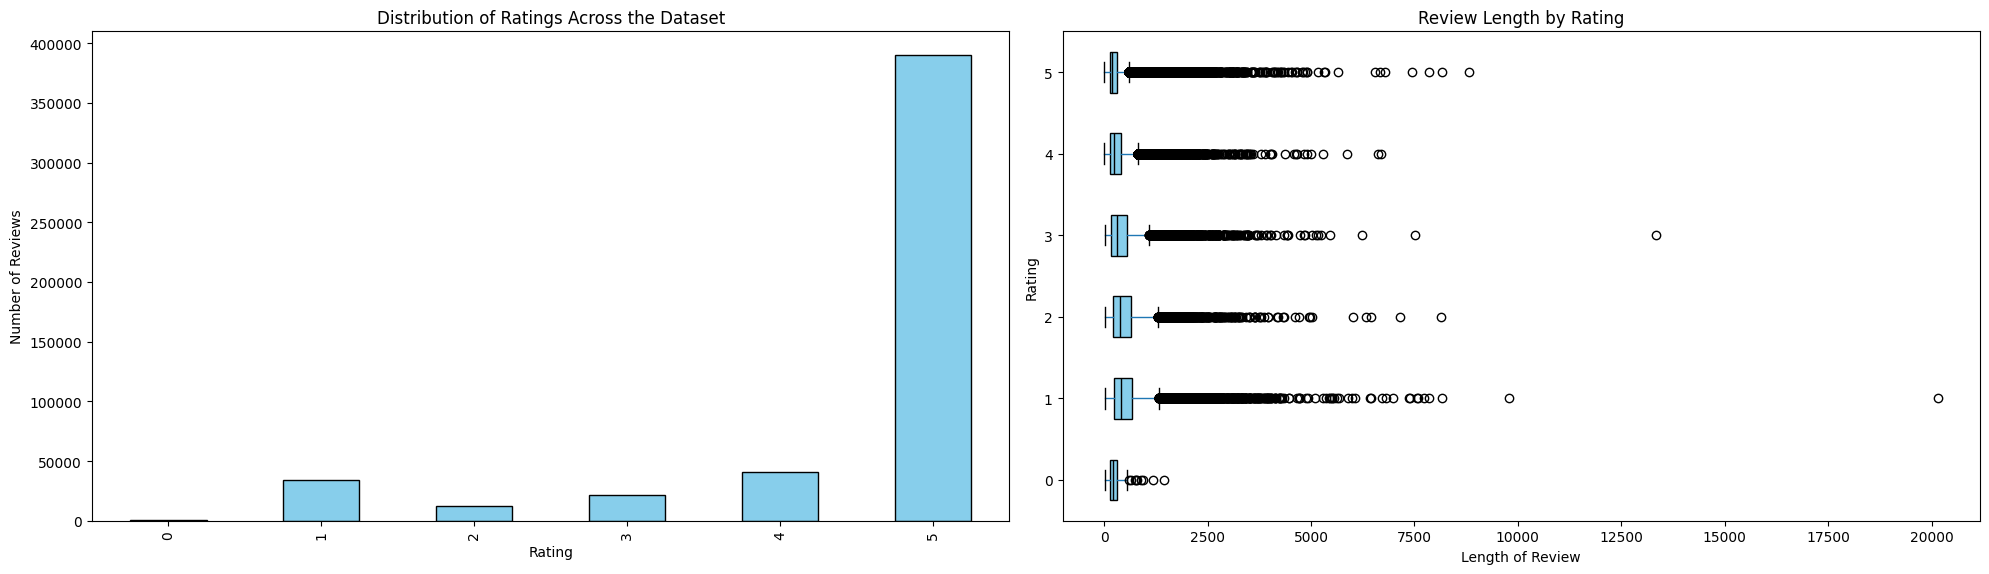

In [339]:
# Создаем подграфики
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Строим гистограмму распределения рейтингов
data_full['rating'].value_counts().sort_index().plot(kind='bar', color=color, edgecolor=edgecolor, ax=axes[0])
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_title('Distribution of Ratings Across the Dataset')

# Добавляем столбец с длиной отзывов
data_full['review_length'] = data_full['text'].apply(len)

# Строим коробчатую диаграмму длины отзывов по рейтингам
data_full.boxplot(column='review_length', by='rating', ax=axes[1], grid=False, vert=False, patch_artist=True, boxprops=dict(facecolor=color, color=edgecolor), medianprops=dict(color=edgecolor))
axes[1].set_xlabel('Length of Review')
axes[1].set_ylabel('Rating')
axes[1].set_title('Review Length by Rating')

# Отображаем
plt.suptitle('')
plt.tight_layout()
plt.show()

**Вывод:**

- **Тенденция к положительным отзывам:** Большинство отзывов в наборе данных имеют высокие оценки.     

- **Негативные отзывы более детализированы:** Негативные отзывы в среднем длиннее, что свидетельствует о более глубоком анализе и объяснении причин недовольства.       
        
- **Положительные отзывы более краткие:** Отзывы с высокими оценками часто имеют меньшую длину, что может говорить о том, что довольные пользователи не всегда видят необходимость в детализированных комментариях.

Так же видно, что для некоторых рейтингов есть **выбросы — очень длинные отзывы**, которые сильно отклоняются от основной массы данных. Такие тексты могут искажать результаты анализа и обучения модели. Поэтому, можно их удалить перед обучением, чтобы избежать их влияния на модель, улучшить стабильность и производительность, а также сэкономить вычислительные ресурсы.

#### Feature Engineering

In [340]:
# Удаление ненужных столбцов
data_full.drop(columns=['address', 'name_ru'], inplace=True)

Колонки `address` и `name` не будут использоваться в дальнейшем анализе или обучении модели, поэтому они удаляются из данных, чтобы упростить обработку.

In [341]:
# Считаем количество каждого рейтинга
rating_counts = data_full['rating'].value_counts()

# Рассчитываем процентное соотношение каждого рейтинга
rating_percentages = (rating_counts / rating_counts.sum()) * 100

# Создаем таблицу
rating_summary = pd.DataFrame({
    'Count': rating_counts,
    'Percentage': rating_percentages})

# Отображаем 
display(rating_summary)

,Count,Percentage
rating,,
5,390405,78.098963
4,41155,8.232894
1,34351,6.871781
3,21686,4.338198
2,12088,2.418156
0,200,0.040009


- **Рейтинг 5** значительно преобладает в данных, составляя более **78%** от всех отзывов (**390 405** из **500 000**).      

- **Рейтинг 4** также является достаточно распространенным, но его количество гораздо меньше (около **8%** от всех отзывов).     

- Отзывы с низкими оценками (**1, 2, 3**) встречаются реже, особенно с оценками 1 и 2, которые составляют примерно **7%** и **2%** соответственно.  

- **Рейтинг 0** встречается крайне редко (менее **0.04%** от всех данных).

In [342]:
# Удаление отзывов с рейтингом 0
data_full = data_full[data_full['rating'] != 0]

Мы исключаем строки с рейтингом 0, так как их количество крайне мало (менее 0.05% от всех данных), и они могут не быть репрезентативными для обучения модели. 

In [343]:
# Считаем количество отзывов для каждой рубрики
rubrics_review_counts = data_full['rubrics'].value_counts()

# Фильтруем данные, оставляя только те рубрики, у которых больше 1000 отзывов
filtered_data = data_full[data_full['rubrics'].isin(rubrics_review_counts[rubrics_review_counts > 1000].index)]

# Выводим размерность данных
filtered_data.shape

(215297, 4)

Тут мы фильтруем данные, оставляя только те рубрики, которые встречаются более **1000** раз. Это позволяет сосредоточиться на более популярных и репрезентативных категориях и снизить шум в обучении модели. 

In [344]:
# Считаем количество отзывов для каждой рубрики
filtered_data_rubrics_review_counts = filtered_data['rubrics'].value_counts()

# Получаем список названий рубрик
rubric_names = filtered_data_rubrics_review_counts.index.tolist()

# Выводим 
print(f"List of rubrics: {rubric_names}")
print(f"Number of rubrics: {len(rubric_names)}")

List of rubrics: ['Гостиница', 'Ресторан', 'Кафе', 'Супермаркет', 'Магазин продуктов', 'Музей', 'Быстрое питание', 'Ресторан;Кафе', 'Супермаркет;Магазин продуктов', 'Пункт выдачи', 'Аптека', 'Парк культуры и отдыха', 'Достопримечательность', 'Торговый центр', 'Кафе;Ресторан', 'Стоматологическая клиника', 'База, дом отдыха', 'Торговый центр;Развлекательный центр', 'Жилой комплекс', 'Санаторий', 'Банк', 'Салон красоты', 'Пляж', 'АЗС', 'Магазин продуктов;Магазин хозтоваров и бытовой химии;Супермаркет', 'Салон красоты;Парикмахерская;Ногтевая студия', 'Детский сад, ясли', 'Кофейня', 'Турбаза', 'Ресторан;Бар, паб;Кафе', 'Столовая', 'Железнодорожный вокзал', 'Магазин алкогольных напитков;Магазин продуктов', 'Театр', 'Бар, паб', 'Ресторан;Бар, паб', 'Железнодорожная станция', 'Парк культуры и отдыха;Лесопарк;Сквер', 'Магазин продуктов;Супермаркет', 'Быстрое питание;Кафе', 'Аэропорт', 'Автомойка', 'Кафе;Быстрое питание', 'Продуктовый гипермаркет', 'Автосервис, автотехцентр', 'Ногтевая студия', 

Группировка рубрик в более широкие категории базируется на схожести между ними. Поскольку содержание отзывов для таких рубрик, как "Кафе", "Ресторан" и "Быстрое питание", вероятно, будет очень похожим (например, обсуждение еды и сервиса), объединение их в одну категорию помогает модели сосредоточиться на ключевых признаках.

In [111]:
# Группировка рубрик в более широкие категории
category_mapping = {
    'Общественное питание': [ # +
        'Ресторан',
        'Кафе',
        'Бар, паб',
        'Бар, паб;Кафе;Ресторан',
        'Быстрое питание',
        'Ресторан;Кафе',
        'Ресторан;Бар, паб;Кафе',
        'Ресторан;Банкетный зал',
        'Ресторан;Доставка еды и обедов',
        'Кафе;Ресторан',
        'Доставка еды и обедов',
        'Столовая',
        'Кофейня',
        'Быстрое питание;Кафе',
        'Кафе;Быстрое питание',
        'Ресторан;Бар, паб',
        'Ресторан;Кафе;Банкетный зал'
    ],
    'Магазины и Супермаркеты': [ # +
        'Супермаркет',
        'Магазин продуктов',
        'Супермаркет;Магазин продуктов',
        'Магазин продуктов;Магазин хозтоваров и бытовой химии;Супермаркет',
        'Магазин продуктов;Супермаркет',
        'Товары для дома;Магазин хозтоваров и бытовой химии;Магазин подарков и сувениров;Магазин фиксированной цены',
        'Продуктовый гипермаркет',
        'Магазин алкогольных напитков;Магазин продуктов'
    ],
    'Торговые и Развлекательные Центры': [
        'Торговый центр',
        'Торговый центр;Развлекательный центр'
    ],
    'Развлечения и Культура': [
        'Музей',
        'Театр',
        'Кинотеатр',
        'Зоопарк',
        'Достопримечательность',
        'Смотровая площадка'
    ],
    'Медицинские Учреждения': [ # +
        'Аптека',
        'Больница для взрослых',
        'Поликлиника для взрослых',
        'Медцентр, клиника',
        'Стоматологическая клиника'
    ],
    'Образовательные Учреждения': [
        'Детский сад, ясли'
    ],
    'Гостиницы и Размещение': [ # +
        'Гостиница',
        'Хостел',
        'Санаторий',
        'База, дом отдыха'
    ],
    'Банки и Финансовые Учреждения': [
        'Банк'
    ],
    'Парки и Зоны Отдыха': [
        'Парк культуры и отдыха',
        'Парк культуры и отдыха;Лесопарк;Сквер',
        'Пляж',
        'Турбаза'
    ],
    'Транспортные Узлы': [
        'Аэропорт',
        'Железнодорожный вокзал',
        'Железнодорожная станция',
    ],
    'Транспортные Сервисы': [
        'АЗС',
        'Автомойка',
        'Автосервис, автотехцентр'
    ],
    'Салоны Красоты и Услуги': [ # +
        'Салон красоты',
        'Парикмахерская',
        'Ногтевая студия',
        'Барбершоп;Салон красоты;Парикмахерская',
        'Салон красоты;Парикмахерская;Ногтевая студия'
    ],
    'Прочие Категории': [
        'Пункт выдачи',
        'Жилой комплекс',
        'Православный храм',
        'Пекарня'
    ]
}

In [ ]:
# Функция для назначения новых категорий
def map_to_general_category(rubric):
    for general_category, specific_categories in category_mapping.items():
        if rubric in specific_categories:
            return general_category
    return 'Неизвестная категория'

# Применяем функцию к столбцу 'rubrics' и создаем новый столбец 'category'
filtered_data.loc[:, 'category'] = filtered_data['rubrics'].apply(map_to_general_category)

In [347]:
# Группировка по категориям и подсчет распределения рейтингов
category_rating_distribution = filtered_data.groupby('category')['rating'].value_counts().unstack(fill_value=0)

# Переименовываем столбцы
category_rating_distribution.columns = [f'rating {col}' for col in category_rating_distribution.columns]

# Считаем количество отзывов для каждой категории
category_text_counts = filtered_data['category'].value_counts().rename('reviews')

# Объединяем данные в одну таблицу
category_summary = pd.concat([category_text_counts, category_rating_distribution], axis=1).fillna(0).astype(int)

# Отображаем 
display(category_summary)

,reviews,rating 1,rating 2,rating 3,rating 4,rating 5
category,,,,,,
Общественное питание,59707,3988,1990,3348,5650,44731
Гостиницы и Размещение,49860,1806,1279,2962,6807,37006
Магазины и Супермаркеты,27522,1850,841,2021,4110,18700
Развлечения и Культура,14245,328,225,565,1334,11793
Медицинские Учреждения,11305,1221,297,504,796,8487
Парки и Зоны Отдыха,10341,233,231,575,1315,7987
Прочие Категории,10032,809,257,438,812,7716
Салоны Красоты и Услуги,8708,581,125,127,141,7734
Торговые и Развлекательные Центры,7149,227,142,422,1079,5279


In [ ]:
# Делаем выборку категорий
categories_of_interest = ['Общественное питание', 'Гостиницы и Размещение', 'Магазины и Супермаркеты']

# Фильтруем 
filtered_data_of_interest = filtered_data[filtered_data['category'].isin(categories_of_interest)]

Тут мы ограничиваем данные только теми категориями, которые имеют больше отзывов, они могут быть полезны для построения более точной модели. 

In [ ]:
# Определяем длину отзывов
filtered_data_of_interest.loc[:, 'text_length'] = filtered_data_of_interest['text'].apply(len)

In [ ]:
# Фильтрация по длине
filtered_data_of_interest = filtered_data_of_interest[(filtered_data_of_interest['text_length'] >= 30) & (filtered_data_of_interest['text_length'] <= 1500)]

Мы удаляем отзывы с длиной текста менее 30 символов и более 1500 символов, так как:

- Очень короткие отзывы (меньше 30 символов) скорее всего не содержат достаточно информации и могут быть неинформативными для модели.

- Очень длинные отзывы (больше 1500 символов) могут быть избыточными или содержать много нерелевантных данных, что затруднит обработку и обучение модели.

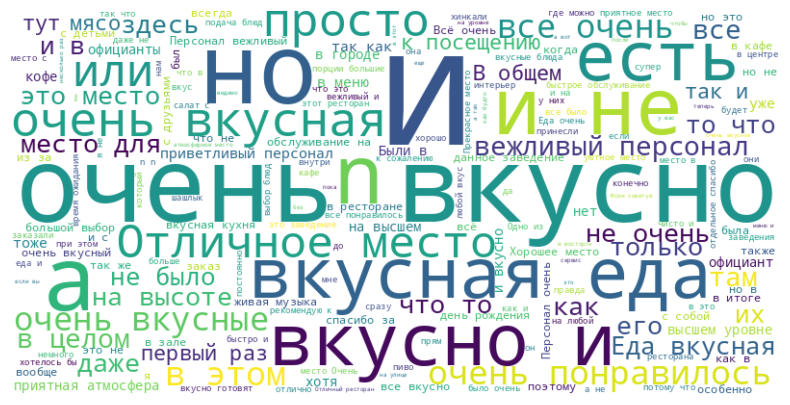

In [155]:
# Генерируем облако слов
rubric_data = filtered_data_of_interest[filtered_data_of_interest['category'] == 'Общественное питание']
text_combined = " ".join(rubric_data['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

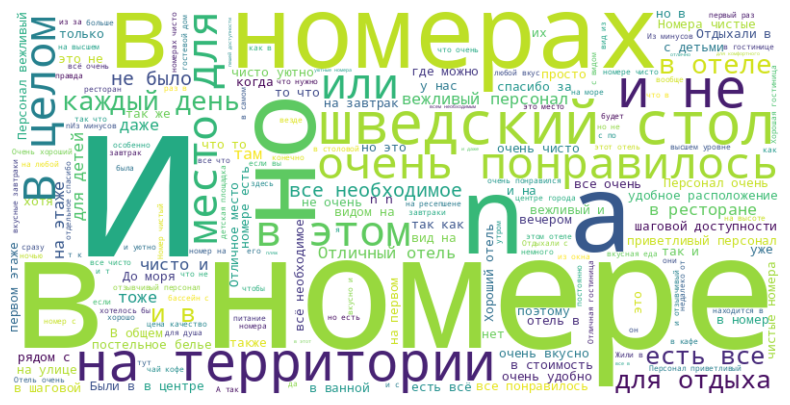

In [156]:
# Генерируем облако слов
rubric_data = filtered_data_of_interest[filtered_data_of_interest['category'] == 'Гостиницы и Размещение']
text_combined = " ".join(rubric_data['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

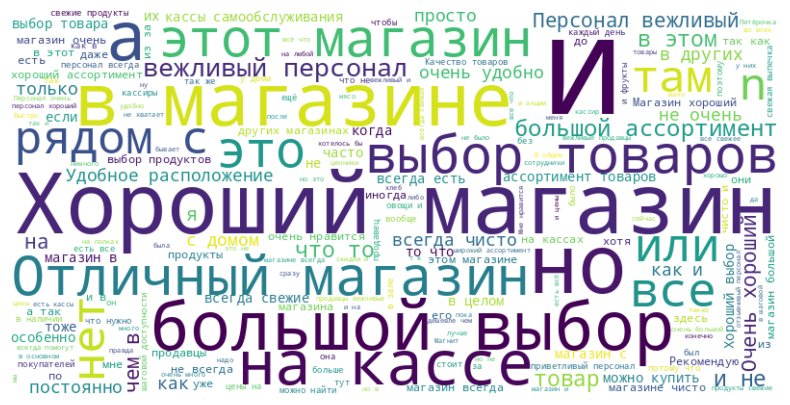

In [256]:
# Генерируем облако слов
rubric_data = filtered_data_of_interest[filtered_data_of_interest['category'] == 'Магазины и Супермаркеты']
text_combined = " ".join(rubric_data['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Отбираем столбцы
data = filtered_data_of_interest[['category', 'rating', 'text']]
# Сбрасываем индексы
data.reset_index(drop=True, inplace=True)

#### Text Processing

In [258]:
# Определяем паттерны для очистки текста
pattern_n = re.compile(r'\bn\d+\b')
pattern_parentheses = re.compile(r'[()]')
pattern_space_before_punct = re.compile(r'\s+([.,!?;:])')
pattern_multiple_punct = re.compile(r'([.!?]){2,}')
pattern_whitespace = re.compile(r'\s+')
pattern_duplicate_words = re.compile(r'\b(\w+)\s+\1\b', flags=re.IGNORECASE)

# Функция для очистки текста
def clean_text(text):
    if not isinstance(text, str):
        return None

    # Удаляем паттерны из текста
    text = pattern_n.sub('', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.replace("\n", " ").replace("\\n", " ").replace("\\", "")
    text = pattern_parentheses.sub('', text)
    text = pattern_space_before_punct.sub(r'\1', text)
    text = pattern_multiple_punct.sub(lambda m: m.group(1), text)
    text = pattern_whitespace.sub(' ', text)
    text = pattern_duplicate_words.sub(r'\1', text)
    
    return text.strip()

# Пример текста для очистки
text = data['text'][161]
print(text)

# Очистка текста
clean = clean_text(text)
print(clean)

По-моему, тут все прекрасно!) Чисто, вежливые официанты, еда и напитки - это отдельная песня, вкусно было абсолютно всё! Да, цены высокие, но и это не забегаловка)
По-моему, тут все прекрасно! Чисто, вежливые официанты, еда и напитки - это отдельная песня, вкусно было абсолютно всё! Да, цены высокие, но и это не забегаловка


Код выполняет очистку текста, удаляя шум, такой как числовые токены, эмоджи, лишние пробелы, повторяющиеся знаки препинания и дублирующиеся слова (например, "очень очень"). Это помогает убрать нерелевантные элементы, улучшая качество данных для обучения модели.

In [ ]:
# Применяем очистку
data.loc[:, 'clean_text'] = data['text'].progress_apply(clean_text)

В этом коде мы загружаем предобученную модель для анализа тональности.

**Гипотеза:**   

Мы предполагаем, что анализ тональности позволит выделить наиболее яркие примеры, демонстрирующие явно выраженные положительные или отрицательные эмоции, которые могут быть полезны для дальнейшего анализа.

In [260]:
# Задаем модель для анализа тональности
sentiment_model = 'cointegrated/rubert-tiny-sentiment-balanced'

# Загружаем токенизатор и модель
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model)

# Функция для определения тональности текста
def get_sentiment(text, return_type='label'):
    """ Calculate sentiment of a text. `return_type` can be 'label', 'score' or 'proba' """
    with torch.no_grad():
        inputs = sentiment_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        proba = torch.sigmoid(sentiment_model(**inputs).logits).cpu().numpy()[0]
    if return_type == 'label':
        return sentiment_model.config.id2label[proba.argmax()]
    elif return_type == 'score':
        return proba.dot([-1, 0, 1])
    return proba

# Пример текста и рейтинга для анализа
text = data['text'][2]
rating = data['rating'][2]

# Выводим рейтинь отзыв и тональность
print(f"Rating: {rating},\nReview: {text}")
print(f"Class: {get_sentiment(text, 'label')}")

Rating: 5,
Review: Добрый день! Сегодня во второй раз посетили с дочкой ресторан, нравится меню (куриный суп-лапша, пицца 4 сыра, яблочный штрудель; сациви из курицы, облепиховый чай-то, что успели попробовать за эти 2 посещения) и особенно порадовало прекрасное обслуживание, спасибо Алле за заботу и предупредительность! Разумное соотношение цены и качества, приятная атмосфера в заведении вызывают желание снова посетить и порекомендовать это место. Спасибо, и успехов! С уважением, Оксана и Злата.
Class: positive


In [ ]:
# Применяем анализ
data['sentiment'] = data['text'].apply(lambda x: get_sentiment(x, 'label'))

In [306]:
# Создаем сводную таблицу, группируя данные по рейтингу и тональности
pivot_table = data.pivot_table(index='rating', columns='sentiment', aggfunc='size', fill_value=0)

# Отображаем
display(pivot_table)

sentiment,negative,neutral,positive
rating,,,
1,5470,1413,477
2,2057,1326,537
3,2629,3403,2013
4,1986,5016,9259
5,5185,8248,85979


**Негативные:**

Отзывы с рейтингами 1 и 2 негативны, так как они явно отражают неудовлетворение. Для точности добавляются только отзывы с тональностью negative.

**Нейтральные:**

Рейтинг 3 относится к нейтральным отзывам, так как не выражает сильной эмоциональной окраски.
Для увеличения выборки добавляем отзывы с рейтингом 4, но только если их тональность была определена как neutral.

**Позитивные:**

Отзывы с рейтингами 4 и 5, имеющие тональность только positive.

Учет и рейтинга, и тональности улучшает качество категоризации.
Помогает сбалансировать классы, особенно для нейтральных отзывов, где выборка может быть небольшой.
Повышает точность анализа и обучения модели, убирая неоднозначные случаи.

In [ ]:
# Фильтруем отрицательные отзывы с рейтингом 1 или 2
negative_reviews = data[(data['sentiment'] == 'negative') & (data['rating'].isin([1, 2]))]

# Фильтруем нейтральные отзывы с рейтингом 3 или 4
neutral_reviews = data[(data['sentiment'] == 'neutral') & (data['rating'].isin([3, 4]))]

# Фильтруем положительные отзывы с рейтингом 4 или 5
positive_reviews = data[(data['sentiment'] == 'positive') & (data['rating'].isin([4, 5]))]

# Объединяем
final_sample = pd.concat([negative_reviews, neutral_reviews, positive_reviews])

In [308]:
# Группируем данные 
sentiment_summary = final_sample.groupby(['category', 'sentiment']).size().unstack(fill_value=0)

# Отображаем
display(sentiment_summary)

sentiment,negative,neutral,positive
category,,,
Гостиницы и Размещение,1609,2935,37176
Магазины и Супермаркеты,1806,2611,16770
Общественное питание,4112,2873,41292


**Проблема:** В исходных данных классы тональности (negative, neutral, positive) сильно дисбалансированы: позитивных отзывов больше, чем нейтральных или негативных. Это может привести к тому, что модель будет плохо распознавать меньшинственные классы.

**Решение:** Для каждой категории мы применяем метод Random UnderSampling, чтобы выровнять количество примеров для каждого класса тональности. Это помогает избежать перекоса модели в сторону более представленных классов и улучшает её способность различать тональности.

**Альтернатива:** придать вес классам при обучении 

Для каждого класса выбирается равное количество примеров, соответствующее количеству в минимальном (в данном случае 1609).

In [309]:
# Инициализируем RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Создаем список для хранения данных
undersampled_data = []
target_samples = 1609

# Проходим по каждой уникальной категории
for category in final_sample['category'].unique():
    # Фильтруем данные по текущей категории
    category_data = final_sample[final_sample['category'] == category]
    X = category_data.drop(columns=['sentiment', 'category'])
    y = category_data['sentiment']
    
    # Определяем стратегию 
    sampling_strategy = {label: target_samples for label in y.unique()}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

    # Применяем
    X_resampled, y_resampled = rus.fit_resample(X, y)
    
    # Объединяем данные
    undersampled_category = pd.concat([X_resampled, y_resampled], axis=1)
    undersampled_category['category'] = category
    undersampled_data.append(undersampled_category)

# Объединяем все данные
balanced_data = pd.concat(undersampled_data)

# Группируем данные по категориям и тональности, подсчитываем количество
sentiment_summary_balanced = balanced_data.groupby(['category', 'sentiment']).size().unstack(fill_value=0)

# Отображаем
display(sentiment_summary_balanced)

sentiment,negative,neutral,positive
category,,,
Гостиницы и Размещение,1609,1609,1609
Магазины и Супермаркеты,1609,1609,1609
Общественное питание,1609,1609,1609


In [310]:
# Заменяем метки тональности
balanced_data['sentiment'] = balanced_data['sentiment'].replace({
    'negative': 'Негативная',
    'neutral': 'Нейтральная',
    'positive': 'Позитивная'})

In [ ]:
# Оставляем только нужные столбцы
balanced_data = balanced_data[['category', 'sentiment', 'clean_text']]

In [ ]:
# Создаем список для тестового набора данных
test_dataset = []

# Проходим по каждой уникальной категории
for category in balanced_data['category'].unique():
    category_data = balanced_data[balanced_data['category'] == category]
    
    # Проходим по каждой уникальной тональности в текущей категории
    for sentiment in category_data['sentiment'].unique():
        sentiment_data = category_data[category_data['sentiment'] == sentiment]
        
        # Выбираем случайные 9 записей для текущей категории и тональности
        sampled_data = sentiment_data.sample(n=9, random_state=42)
        test_dataset.append(sampled_data)
        
        # Удаляем выбранные записи из сбалансированных данных
        balanced_data = balanced_data.drop(sampled_data.index)

# Объединяем все выбранные данные
test_dataset = pd.concat(test_dataset)

# Сохраняем
test_dataset.to_csv('data/test.csv', index=False)
balanced_data.to_csv('data/balanced.csv', index=False)

Выделяем 9 примеров из каждой категории и каждого класса тональности для создания тестового набора, который можно будет использовать для проверки обученной модели на защите работы.

In [ ]:
# Загружаем данные
balanced_data = pd.read_csv('data/balanced.csv')

# Отображаем
balanced_data.sample(3)

,category,sentiment,clean_text
4687,Общественное питание,Позитивная,Калоритное приятное Место! Оперативное обслужи...
2913,Общественное питание,Нейтральная,"Единственное приличное заведение в округе, где..."
147,Общественное питание,Негативная,"До этого было вкусно, но последний поход разоч..."


In [323]:
# Выводим размерность
balanced_data.shape

(14400, 3)

#### Итог:

В результате проведенной обработки данных у нас сформирован сбалансированный набор данных, содержащий 14400 очищенных отзывов, которые сгруппированы по категориям и тональности. Данные готовы для дальнейшего использования для обучения модели. Этот набор позволяет учитывать равное представление тональностей (негативная, нейтральная, позитивная) в каждой категории, что обеспечит более стабильное и качественное обучение.